In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats

In [2]:
class AR_model():
    def __init__(self, p, data):
        self.data = data
        self.T = len(self.data)
        self.p = p
        self.a = self.estimate_parameters()
        self.predictions = np.array([self.predict_next(1, data[n:n+p])[0] for n in range(0, len(data)-p)])
        self.residuals = self.predictions - data[p:]
        self.sigma = np.std(self.predictions - self.data[p:])
        
    def estimate_parameters(self):
        X_p = np.ones(shape=(self.T-self.p, self.p+1))
        for i in range(self.p):
            X_p[:, self.p-i] = self.data[i:self.T-self.p+i]
        X_T = self.data[self.p:]
        return np.linalg.inv(X_p.T.dot(X_p)).dot(X_p.T).dot(X_T)

    def predict_next(self, n, initial_x_values):
        predicted_values = np.zeros(len(initial_x_values) + n)
        predicted_values[:self.p] = initial_x_values
        
        for j in range(n):
            sum = self.a[0]
            for i in range(1, self.p+1):
                sum += self.a[i]*predicted_values[self.p+j-i]
            predicted_values[self.p+j] = sum
        
        return predicted_values[self.p:]
    
def acorr(ts, max_lag):
    lags = np.arange(max_lag)
    result = np.zeros(lags.shape)
    mean_ts = ts.mean()
    T = len(ts)
    gamma_0 = 1/T * np.sum((ts-mean_ts)**2)
    for i, tau in enumerate(lags):
        if tau == 0:
            gamma_tau = gamma_0
        else:
            gamma_tau = 1/(T-tau) * np.sum((ts[:-tau]-mean_ts) * (ts[tau:]-mean_ts))
        result[i] = gamma_tau / gamma_0
    return lags, result

def pacorr(ts, max_order):
    orders = np.arange(1, max_order)
    pacorr_estimates = np.zeros(len(orders))
    for p in orders:
        ar_model = AR_model(p, ts)
        pacorr_estimates[p-1] = ar_model.a[-1]
    return orders, pacorr_estimates

## Task 1 - Univariate AR models

In [3]:
data = pd.read_csv("ex3file1.csv")
dlpfc_data = data.iloc[:,0].values
print(data)

       DLPFC  DLPFC.1  Parietal  Parietal.1
0    2.28550 -0.29516  -3.03620    -4.51840
1    0.85457 -2.63380  -4.52230    -1.90250
2   -0.26151 -3.08110  -4.71460     0.47887
3   -1.19410 -2.62330  -3.97540     1.92820
4   -1.27900 -1.61420  -2.01040     3.77230
..       ...      ...       ...         ...
355 -2.13940 -2.24390  -0.60644    -4.15580
356 -1.32430 -2.30090  -1.01920    -3.81420
357 -1.62290 -3.47130  -2.59440    -4.29070
358 -1.31880 -3.15880  -2.61050    -3.56520
359 -0.51186 -2.72170  -2.49090    -1.62220

[360 rows x 4 columns]


In [4]:
p = 4
ar4 = AR_model(4, dlpfc_data)
with np.printoptions(suppress=True, precision=5):
    print(ar4.a)
    print(ar4.sigma, ar4.sigma**2)
    

[-0.00046  1.24878 -0.48325  0.24285 -0.16991]
0.6760516886161941 0.4570458856808075


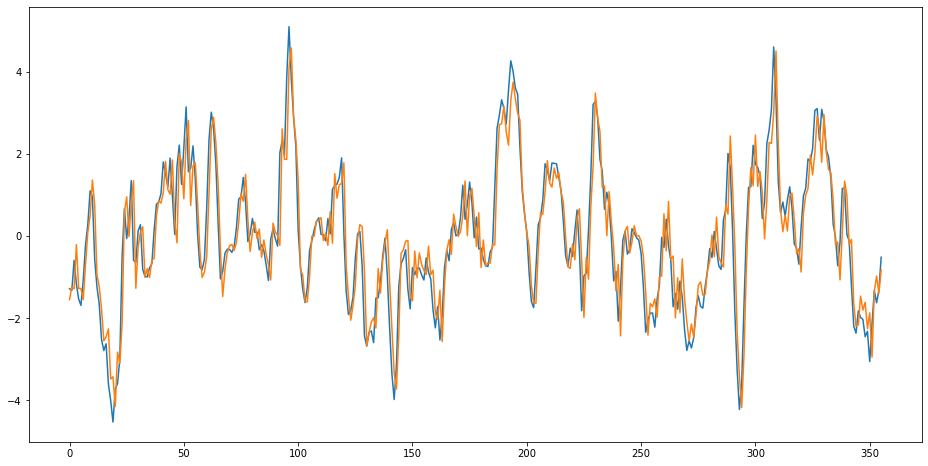

In [5]:
plt.figure(figsize=(16,8))
plt.plot(dlpfc_data[p:])
plt.plot(ar4.predictions)
plt.show()

### 1. Compute the log-likelihood of an AR(4) model

According to the script, the log-likelihood is given as:

$$
\log L(\{ \alpha_i \}, \sigma) = - \frac{T-p}{2} \log (2 \pi) - \frac{T-p}{2} \log(\sigma^2) - \frac{1}{2} \underline{\varepsilon}^T \underline{\varepsilon} \sigma^{-2}
$$

where $\{ \alpha_i \}$ is the set of model coefficients, $\sigma$ is the standard deviation of the process noise $\underline{\varepsilon} \sim \mathcal{N}(0, \sigma^2 \underline{I})$, $T$ is the length of the time series, and $p$ is the order of the AR process.


In [6]:
def log_likelihood(ar_model):
    epsilon = ar_model.residuals
    T = ar_model.T
    p = ar_model.p
    sigma = ar_model.sigma
    return -(T-p)/2 * np.log(2*np.pi) - (T-p) * np.log(sigma) - np.dot(epsilon, epsilon)/(2*sigma**2)
print(log_likelihood(ar4))

-365.77319316608975


### 2. Plot the residuals of the model in a histogram. What do they look like? What do you expect?

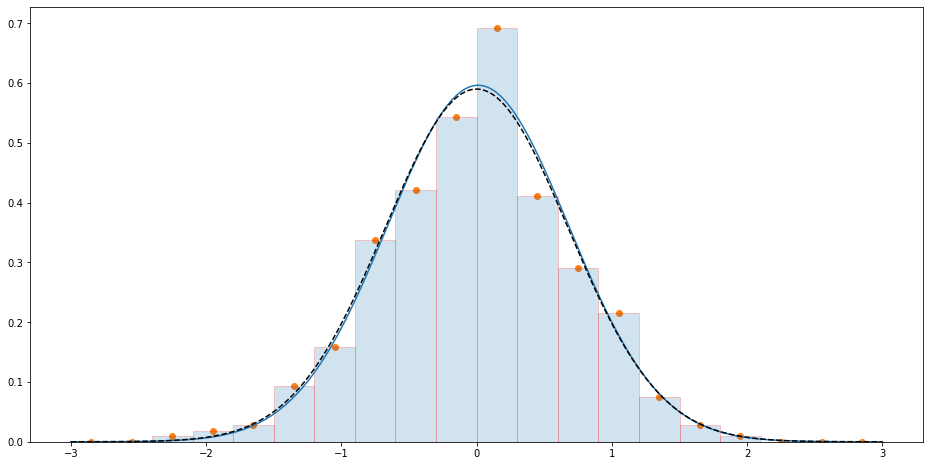

In [7]:
def gaussian(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mu)**2/(2*sigma**2))

hist, bins = np.histogram(ar4.residuals, bins=20, range=[-3,3], density=True)
bin_mids = bins[:-1]+np.diff(bins)/2
popt, pcov = curve_fit(gaussian, bin_mids, hist, p0=[0,1])
x = np.linspace(-3,3,1000)


plt.figure(figsize=(16,8))
plt.bar(bins[:-1], hist, edgecolor="r", alpha=0.2, width=np.diff(bins), align='edge')
plt.scatter(bin_mids, hist)
plt.plot(x, gaussian(x, *popt))
plt.plot(x, stats.norm.pdf(x, scale=ar4.sigma), "--", color="k")
plt.show()


### 3. Compute the log-likelihood of an AR(n) model, with n ranging from 1...5. How does the likelihood change when you increase the order of the model?


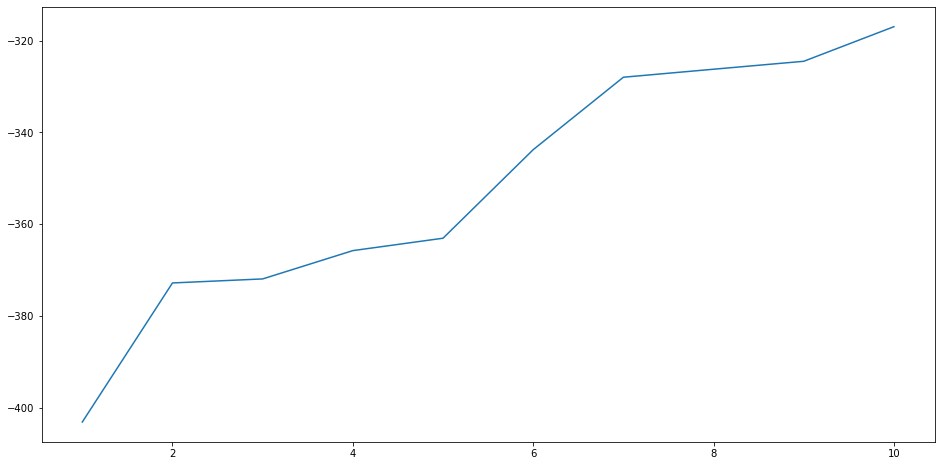

In [8]:
ps = np.arange(1, 10+1)
log_likelihoods = [log_likelihood(AR_model(p, dlpfc_data)) for p in ps]

plt.figure(figsize=(16,8))
plt.plot(ps, log_likelihoods)
plt.show()

In [9]:
def Wilk_test_ll(restricted_model, full_model):
    D = -2 * (log_likelihood(restricted_model) - log_likelihood(full_model))
    dof = full_model.p - restricted_model.p
    p_value = stats.chi2.sf(D, df=dof)
    return D, p_value

def Wilk_test_log_var(restricted_model, full_model):
    D = (restricted_model.T-restricted_model.p)*(np.log(restricted_model.sigma) - np.log(full_model.sigma))
    dof = full_model.p - restricted_model.p
    p_value = stats.chi2.sf(D, df=dof)
    return D, p_value

In [10]:
p_values = [Wilk_test_ll(AR_model(p, dlpfc_data), AR_model(p+1, dlpfc_data))[1] for p in ps]
p_values2 = [Wilk_test_log_var(AR_model(p, dlpfc_data), AR_model(p+1, dlpfc_data))[1] for p in ps]

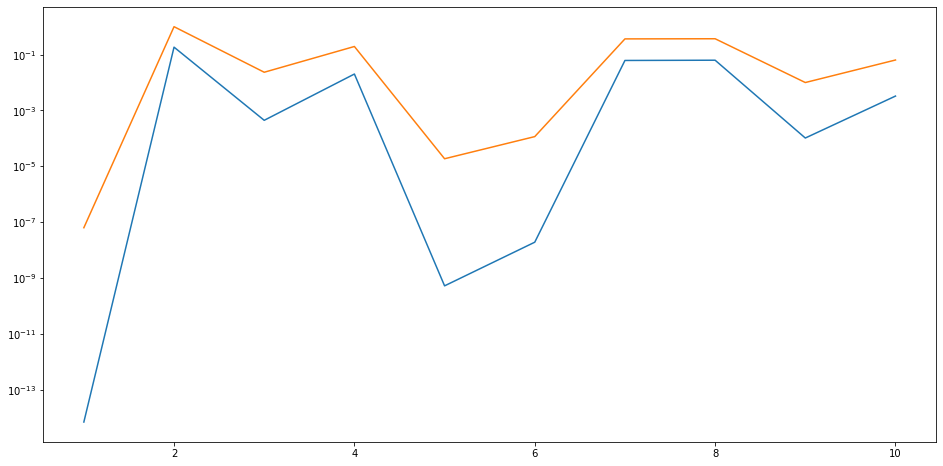

In [11]:
plt.figure(figsize=(16,8))
plt.plot(ps, p_values)
plt.plot(ps, p_values2)
plt.yscale("log")

## Task 2 - Multivariate (vector) AR (=VAR) processes

## Task 3 - AR Poisson Process
### 1. Create your own second order Poisson time series

In [141]:
def create_AR_poisson_data(T, mu0, As, a0):
    mu = mu0
    c_arr = np.zeros(shape=(T, len(a0)))
    c_arr[0] = np.random.poisson(mu, 2)
    
    M = len(As)
    for t in range(1, T):
        log_mu_t = a0.copy()
        for m in range(1, min(M, t)+1):
            log_mu_t += As[m-1].dot(c_arr[t-m])
        mu = np.exp(log_mu_t)
        c_arr[t] = np.random.poisson(mu, 2)
        
    return c_arr

In [151]:
T = 1000
A1 = np.array([
    [0.2, -0.1],
    [0.1, 0.1]
])
A2 = np.array([
    [0.1, -0.1],
    [0.1, 0.1]
])
mu0 = np.array([0.5, 0.5]).T
a0 = np.array([0.0, 0.0]).T
c_arr = create_AR_poisson_data(T, mu0, [A1, A2], a0)


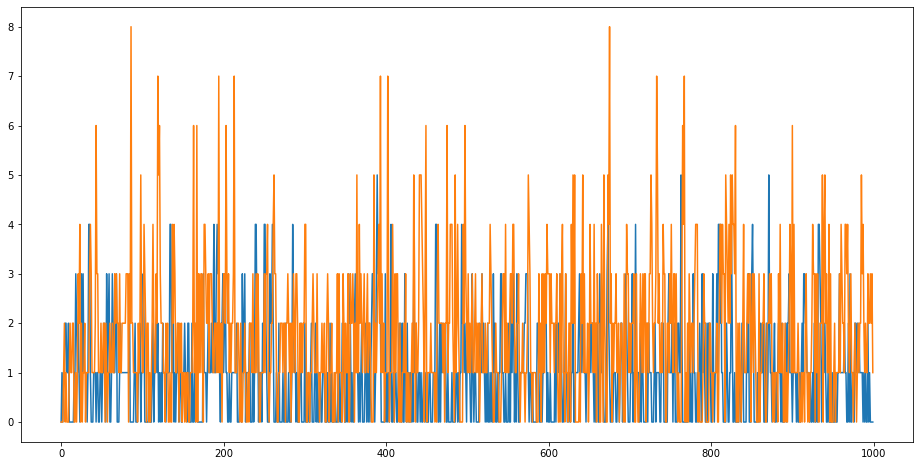

In [152]:
plt.figure(figsize=(16,8))
plt.plot(c_arr[:,0])
plt.plot(c_arr[:,1])
plt.show()

### 2. Given the data generated in 1., vary the parameters $A_1(1,1)$ and $A_2(2,1)$ between $0$ and $0.4$ with $0.01$ increments. For each parameter value pair, compute the log-likelihood of the data (keeping all other parameters fixed!). Plot the log-likelihood landscape surface as a function of these two parameters. Does the real parameter pair value correspond (or is close) to an extreme point in the approximate log-likelihood landscape? What kind of an extreme point is it?

In [161]:
def log_likelihood_AR_Poisson(data, As, a0):
    T = len(data)
    M = len(As)
    ll = 0
    mu_arr = np.zeros(shape=data.shape)
    for t in range(M, T):
        log_mu_t = a0.copy()
        for m in range(1, min(t, M)+1):
            log_mu_t += As[m-1].dot(data[t-m])
        
        ll += np.sum(data[t]*log_mu_t-np.exp(log_mu_t))

        
    return ll

In [200]:
parameter_range = np.linspace(0, 0.4, int(0.4/0.01)+1)
lls = np.zeros(shape=(len(parameter_range), len(parameter_range)))
for i, a1 in enumerate(parameter_range):
    for j, a2 in enumerate(parameter_range):
        A1 = np.array([
            [a1, -0.1],
            [0.1, 0.1]
        ])
        A2 = np.array([
            [0.1, -0.1],
            [a2, 0.1]
        ])
        lls[i,j] = log_likelihood_AR_Poisson(c_arr, [A1, A2], a0)

In [240]:
argmax_indices = np.unravel_index(lls.argmax(), lls.shape)
print(argmax_indices, (parameter_range[argmax_indices[0]], parameter_range[argmax_indices[1]]), lls[argmax_indices])
print((20,10), (parameter_range[20], parameter_range[10]), lls[20,10])

(18, 11) (0.18, 0.11) -1642.5349718827197
(20, 10) (0.2, 0.1) -1643.6655353670878


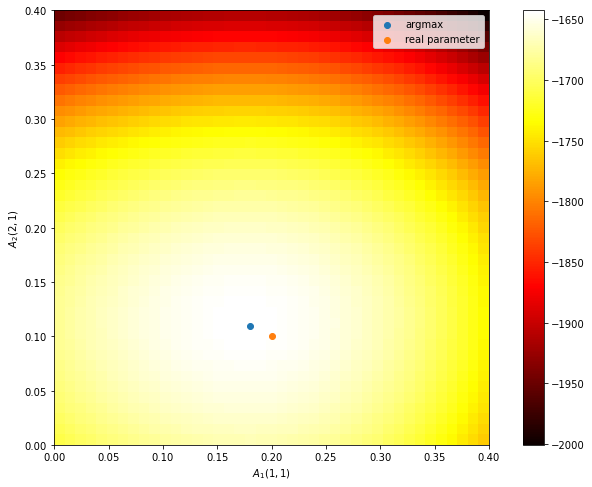

In [238]:
plt.figure(figsize=(12,8))
ax = plt.gca()
plt.imshow(lls.T, cmap='hot', interpolation='nearest', extent=[0,0.4,0,.4], origin='lower')
plt.colorbar()
plt.scatter(parameter_range[argmax_indices[0]], parameter_range[argmax_indices[1]], label="argmax")
plt.scatter(0.2, 0.1, label="real parameter")
plt.xlabel(r"$A_1(1,1)$")
plt.ylabel(r"$A_2(2,1)$")
plt.legend()
plt.show()

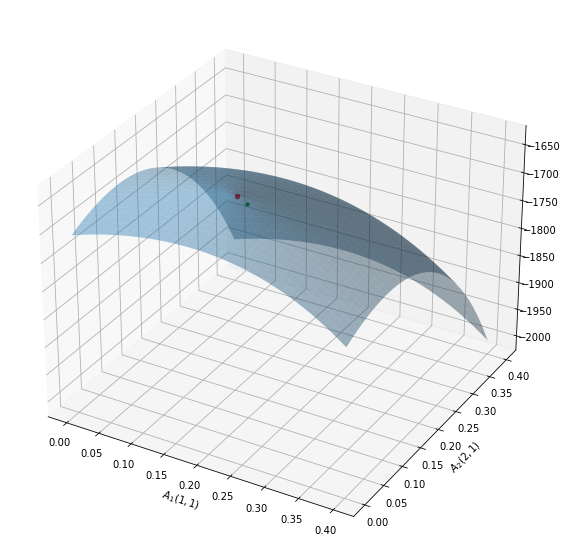

In [243]:
X, Y = np.meshgrid(parameter_range, parameter_range)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, lls.T, alpha=0.4)
ax.scatter(parameter_range[argmax_indices[0]], parameter_range[argmax_indices[1]], lls[argmax_indices], label="argmax", s=20, c="r")
ax.scatter(0.2, 0.1, lls[20,10], label="argmax", s=10, c="g")
plt.xlabel(r"$A_1(1,1)$")
plt.ylabel(r"$A_2(2,1)$")
plt.show()